In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
!pip install -q tensorflow_datasets

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [4]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+ metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])
    plt.show()

In [5]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True
train_dataset, test_dataset = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete01J4HO/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete01J4HO/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete01J4HO/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [9]:
info.features['text']

Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8185>)

In [6]:
encoder = info.features['text'].encoder

In [10]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print("Encoded string is {}".format(encoded_string))

original_string = encoder.decode(encoded_string)
print("The original string: '{}'".format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: 'Hello TensorFlow.'


In [11]:
for index in encoded_string:
    print('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


In [12]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [13]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)

test_dataset = test_dataset.padded_batch(BATCH_SIZE)

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [15]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             optimizer=tf.keras.optimizers.Adam(1e-4),
             metrics=['accuracy'])

In [17]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30)

Epoch 1/10
391/391 [==============================] - 35s 89ms/step - loss: 0.6569 - accuracy: 0.5466 - val_loss: 0.4547 - val_accuracy: 0.7927
Epoch 2/10
391/391 [==============================] - 35s 89ms/step - loss: 0.3417 - accuracy: 0.8530 - val_loss: 0.3402 - val_accuracy: 0.8615
Epoch 3/10
391/391 [==============================] - 35s 89ms/step - loss: 0.2430 - accuracy: 0.9068 - val_loss: 0.3301 - val_accuracy: 0.8594
Epoch 4/10
391/391 [==============================] - 35s 89ms/step - loss: 0.2070 - accuracy: 0.9242 - val_loss: 0.3284 - val_accuracy: 0.8708
Epoch 5/10
391/391 [==============================] - 35s 89ms/step - loss: 0.2260 - accuracy: 0.9113 - val_loss: 0.3675 - val_accuracy: 0.8542
Epoch 6/10
391/391 [==============================] - 35s 89ms/step - loss: 0.1680 - accuracy: 0.9370 - val_loss: 0.3565 - val_accuracy: 0.8630
Epoch 7/10
391/391 [==============================] - 35s 89ms/step - loss: 0.1472 - accuracy: 0.9487 - val_loss: 0.3978 - val_accuracy:

In [19]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 16s 40ms/step - loss: 0.4348 - accuracy: 0.8538
Test Loss: 0.4347863793373108
Test Accuracy: 0.8537999987602234


In [20]:
def pad_to_size(vec, size):
    zeros = [0] * (size - len(vec))
    vec.extend(zeros)
    return vec

In [21]:
def sample_predict(sample_pred_text, pad):
    encoded_sample_pred_text = encoder.encode(sample_pred_text)
    
    if pad:
        encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
    encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
    predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

    return (predictions)

In [22]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[-0.35890928]]


In [23]:
# predict on a sample text with padding

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[-0.26276377]]


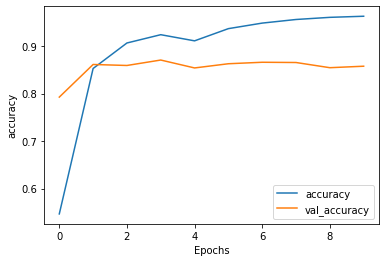

In [24]:
plot_graphs(history, 'accuracy')

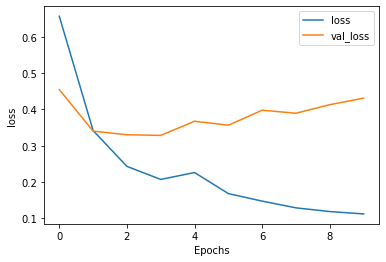

In [25]:
plot_graphs(history, 'loss')

Keras 반복 레이어에는 ```return_sequences``` 생성자 인수로 제어되는 두 가지 사용 가능한 모드가 있습니다.

- 각 시간 단계에 대한 연속 출력의 전체 시퀀스 (3D 텐서 모양 (batch_size, timesteps, output_features))를 반환합니다.
- 각 입력 시퀀스에 대한 마지막 출력 만 반환합니다 (형태의 2D 텐서 (batch_size, output_features)).

In [26]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [27]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [28]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 63s 162ms/step - loss: 0.6429 - accuracy: 0.5706 - val_loss: 0.4750 - val_accuracy: 0.7641
Epoch 2/10
391/391 [==============================] - 62s 159ms/step - loss: 0.3543 - accuracy: 0.8560 - val_loss: 0.3561 - val_accuracy: 0.8531
Epoch 3/10
391/391 [==============================] - 63s 160ms/step - loss: 0.2580 - accuracy: 0.9049 - val_loss: 0.3595 - val_accuracy: 0.8646
Epoch 4/10
391/391 [==============================] - 62s 160ms/step - loss: 0.2116 - accuracy: 0.9274 - val_loss: 0.3967 - val_accuracy: 0.8693
Epoch 5/10
391/391 [==============================] - 63s 161ms/step - loss: 0.1876 - accuracy: 0.9370 - val_loss: 0.4014 - val_accuracy: 0.8667
Epoch 6/10
391/391 [==============================] - 63s 162ms/step - loss: 0.1545 - accuracy: 0.9520 - val_loss: 0.4006 - val_accuracy: 0.8568
Epoch 7/10
391/391 [==============================] - 63s 160ms/step - loss: 0.1366 - accuracy: 0.9582 - val_loss: 0.4427 - val_ac

In [29]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 28s 71ms/step - loss: 0.4857 - accuracy: 0.8548
Test Loss: 0.48569536209106445
Test Accuracy: 0.8547999858856201


In [30]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[-1.7377865]]


In [32]:
# predict on a sample text with padding

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[-3.7761815]]


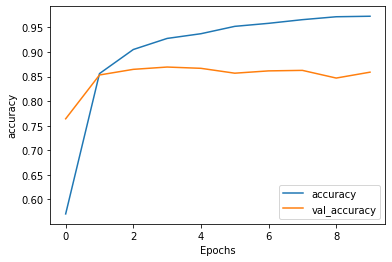

In [33]:
plot_graphs(history, 'accuracy')

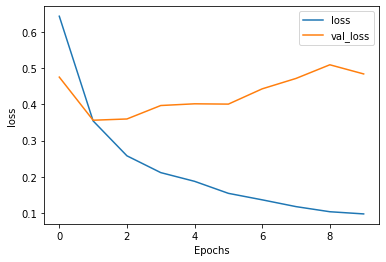

In [34]:
plot_graphs(history, 'loss')